In [1]:
# Jade Chongsathapornpong, August 2023
import os
from os.path import join
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.signal import savgol_filter

from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation

from larch import Group
from larch.io import read_ascii
from larch.xafs import sort_xafs, pre_edge, autobk

# Time evolution in PCA representation
This is the same workflow as `xas-pca-time-evolution`, just with all the excess code needed to load the ROCK data, adapted from `xas-time-evolution-rock`). Shown is a proof-of-concept with the ROCK data collected in June.

In [62]:
##### This is where the BM23 references are defined #####

### Zn K-edge ###
root = r'../Data/BM23_Averaging_PyMCA/Zn_Kedge_Old'
# These are all the end points
names_all = ('HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
         'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C',
         'W32_HEO-Co_RT', 'W36_Zn_RTInit', 'W36_Zn_RTFinal', 'W36_Zn_900C',
         'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
         'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
         'W46_ZnMg_RT', 'ZnO_KOCH_RT')
# This is what we want to fit the PCA to
names_for_pca = ('HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
         'W30_HEO-Mg_RTInit',
         'W32_HEO-Co_RT', 'W36_Zn_RTInit',
         'W37_ZnCo_RTInit',
         'W39_HEO_RTInit',
         'W46_ZnMg_RT', 'ZnO_KOCH_RT')

### Co K-edge ###
# root = r'../Data/BM23_Averaging_PyMCA/Co_Kedge_Old'
# names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C', 'W31_HEO-Zn_RT',
#          'W35_Co_RTInit', 'W35_Co_RTFinal', 'W35_Co_900C',
#          'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal',
#          'W40_CoNi_RT', 'W41_CoCu_RT', 'W42_CoMg_RT', 'W47_Co-doped-ZnO_RT', 'CoO_FDR_RT'] #  'W39_HEO_900C' removed because it's too short?
# names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
#          'W30_HEO-Mg_RTInit', 'W31_HEO-Zn_RT',
#          'W35_Co_RTInit',
#          'W37_ZnCo_RTInit',
#          'W39_HEO_RTInit',
#          'W40_CoNi_RT', 'W41_CoCu_RT', 'W42_CoMg_RT', 'W47_Co-doped-ZnO_RT', 'CoO_FDR_RT']

##### These are the info we need to access the ROCK time-resolved data #####

elem='Zn' # Ensure the selected spectra are for the same element as the BM23 references!!!
root_rock = os.path.join(r'..\Data\ROCK\XAS\WAM39B\WAM39B_Rampe_1', elem + '_Kedge')
edges = {'Co': 7709, 'Cu': 8979, 'Ni': 8333, 'Zn': 9658}

# Selects files in a directory structured like WAM39B_Rampe_1/Zn_Kedge
rock_target_files = []
for directory in os.listdir(root_rock):
    if directory[-3:] != '120':
        continue # we want the ones that are averages of 120 only
    # if we made it here, explore the directory
    path = join(root_rock, directory, 'normalized')
    for file in os.listdir(path):
        # move on if it's not a file of interest
        if file[:7] != ('norm_' + elem) and file[:8] != 'norm_WAM':
            continue # we want to ignore pivot files, for example
        # otherwise add the whole path to target_files
        rock_target_files.append(join(path, file))

## Loading and interpolating data

In [63]:
def interpolate_xas(in_energies, in_signals, targets=None):
    """Args:
        - in_energies (list or iterable of 1D array) energies or wavenumbers, or single 1D array
        - in_signals (list of 1D array)
        - target_energies (1D array) if None, uses the SHORTEST array in in_energies, 
            and interpolates the remaining in_signal arrays to match it.
    Returns:
        - targets (1D array) a single array of energies (or wavenumbers) interpolated to
        - out_signals (list of 1D array) all the interpolated signals
    """
    if targets is None:
        spectrum_lengths = [len(E) for E in in_energies]
        print("Lengths of spectra:", spectrum_lengths)
        shortest_idx = np.argmin(spectrum_lengths)
        print(f"Mapping to {len(in_energies[shortest_idx])} points from spectra up to {np.max(spectrum_lengths)} long")
        targets = in_energies[shortest_idx]
        
    if isinstance(in_energies, list):
        out_signals = [np.interp(targets, energy, signal) for energy, signal in zip(in_energies, in_signals)]
    else:
        out_signals = [np.interp(targets, in_energies, signal) for signal in in_signals]
        
    return targets, np.array(out_signals)

def _larchgroup_init(g, name):
    g.is_frozen = False
    g.datatype = 'xas'
    g.xdat = 1000.*g.data[0,:] if max(g.data[0,:]) < 100 else g.data[0,:]
    g.ydat = g.data[1,:]/1.
    g.yerr = 1.
    g.energy = g.xdat
    g.mu = g.ydat
    sort_xafs(g, overwrite=True, fix_repeats=True)
    g.groupname = name
    g.energy_orig = g.energy[:]
    g.energy_shift = 0. # this could be taken as an argument later?
    g.energy = g.xdat = g.energy_orig + g.energy_shift
    pre_edge(g) # use defaults for pre and post-edge normalization
    g.norm_poly = 1.0 * g.norm
    autobk(g) # use defaults for auto-background-subtraction
    return g
    
def larch_load_group(path, name, labels='energy_cenc, mu_fluo'):
    """Args:
        - path to csv file with labels, e.g. energy_cenc and mu_fluo (can be changed)
        - name to associate with the group
        - labels of columns to read
    Returns:
        - a Larch Group object with attributes initialized as done in xas_viewer
            according to the Larch buffer"""
    g = read_ascii(path, labels=labels)
    return _larchgroup_init(g, name)
                
def load_from_names(names, mode):
    """Args:
        - names of averaged spectra files (formatted as in the first cell)
        - mode 'chik' or 'mu'
    Returns:
        - ordered list of arrays of wavenumbers (mode chik) or energies (mu) corresponding to:
        - ordered list of arrays of relative absorption weighted by k^kweight (chik) or absorptions (mu)
    Uses interpolate_xas to map all signals down to one signal's wavenumbers
    """
    x = []
    y = []
    for name in names:
        path = join(root, name + '.csv')
        lgrp = larch_load_group(path, name)
        if mode == 'chik':
            kweight = 2
            x.append(lgrp.k)
            y.append(lgrp.chi * np.power(lgrp.k, kweight))
        elif mode == 'mu':
            x.append(lgrp.energy)
            y.append(lgrp.mu)
        else:
            raise ValueError('Invalid mode.')
    return interpolate_xas(x, y)

def load_from_rock(paths, mode):
    """Args:
        - paths (list) of paths to normalized ROCK files
        - mode 'chik' or 'mu'
    Returns:
        Same as load_from_names
    """
    x = []
    y = []
    T = []
    print("Loading files from ROCK:", len(paths))
    for p in paths:
        lgrp = larch_load_group(p, p, labels='shifted energy, normalized')
        if mode == 'chik':
            kweight = 2
            x.append(lgrp.k)
            y.append(lgrp.chi * np.power(lgrp.k, kweight))
        elif mode == 'mu':
            x.append(lgrp.energy)
            y.append(lgrp.mu)
        else:
            raise ValueError('Invalid mode.')
    return interpolate_xas(x, y)

def load_temperatures_from_rock(paths, templine=6):
    """Args:
        - paths (list) of paths to normalized ROCK text files
        - templine (int) line index of text files (starting from 0) that contains the temperature 
    Returns:
        - list of corresponding temperatures"""
    T = []
    for p in paths:
        with open(p) as f:
            for i, line in enumerate(f):
                # yes, this is a bit silly, but there's no easy way to read only a specific line it seems?
                if i == templine:
                    temp = float(re.findall(r'\d+.\d+', line)[0])
                    T.append(temp)
                    break
    return T

In [64]:
# Load BM23 reference dataset
mode = 'chik' # since we're using EXAFS data
K, CHIK = load_from_names(names_all, mode) # the long spectra
K_pca, CHI_pca = load_from_names(names_for_pca, mode) # PCA expects (n_samples (each signal is a "sample"), n_features (data pts/signal))

# Load ROCK dataset
K_rock, CHI_rock = load_from_rock(rock_target_files, mode) # This will take a while, and some memory
temperatures_rock = load_temperatures_from_rock(rock_target_files)

Lengths of spectra: [314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314]
Mapping to 314 points from spectra up to 314 long
Lengths of spectra: [314, 314, 314, 314, 314, 314, 314, 314, 314]
Mapping to 314 points from spectra up to 314 long
Loading files from ROCK: 195
Lengths of spectra: [189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189

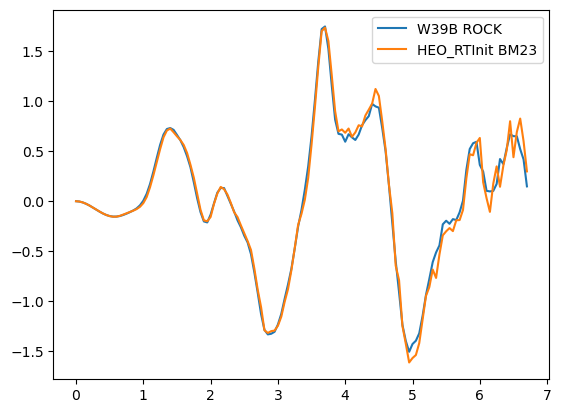

In [65]:
# Cut off glitches/noise (index)
pca_start = 0
pca_end = 135

# Interpolate/truncate the BM23 data to match the ROCK data
K_interp, CHI_interp = interpolate_xas(K, CHIK, targets=K_rock)
_, CHI_pca_interp = interpolate_xas(K_pca, CHI_pca, targets=K_rock)

K_interp = K_interp[pca_start:pca_end]
CHI_interp = CHI_interp[..., pca_start:pca_end]
CHI_pca_interp = CHI_pca_interp[..., pca_start:pca_end]
CHI_rock_cut = CHI_rock[..., pca_start:pca_end]

# plot a few examples (will need to change these depending on data)
plt.plot(K_interp, CHI_rock_cut[0], label='W39B ROCK')
if elem == 'Zn':
    heo_init = -5
elif elem == 'Co':
    heo_init = -7
else:
    heo_init = 0
plt.plot(K_interp, CHI_interp[heo_init], label='HEO_RTInit BM23')
plt.legend()
plt.show()

## PCA and Clustering

[0.61344603 0.36358303 0.01116178 0.00370858 0.00330767 0.00238693]


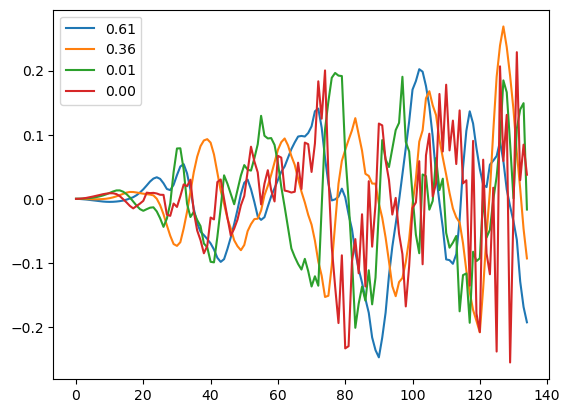

In [66]:
# Fit PCA to the BM23 reference signals chosen for PCA
A = np.array(CHI_pca_interp)
pca = PCA(n_components=6) # adjust this number to get appropriate dimensional embeddings.
pca.fit(A)
print(pca.explained_variance_ratio_)

for i in range(4):
    plt.plot(pca.components_[i], label=f"{pca.explained_variance_ratio_[i]:.2f}")
plt.legend()
# plt.savefig("Output/BM23/Zn_mu_PC")
plt.show()

# Save the principal components
# np.savetxt('Output/BM23/principalcomponents_Zn_mu_short.csv', pca.components_.transpose(), delimiter=',')

In [67]:
# apply PCA to BM23 reference signals
reduced = pca.transform(np.array(CHI_interp))
print(f"Reference: {reduced.shape[0]} signals embedded in {reduced.shape[1]} dimensions.") 
# Save the PCA embeddings of each reference signal
# embedding_df = pd.DataFrame(reduced)
# embedding_df['sample'] = names_all
# embedding_df.to_csv('Output/BM23/pca_embeddings_Zn_mu_short.csv')

# apply PCA to the ROCK experimental signals
reduced_rock = pca.transform(np.array(CHI_rock_cut))
print(f"Experiment: {reduced_rock.shape[0]} signals embedded in {reduced_rock.shape[1]} dimensions.") 

# Perform clustering on the references
ap = AffinityPropagation().fit(reduced)
clusterings = {key: [] for key in np.unique(ap.labels_)}
for i, name in enumerate(names_all):
    clusterings[ap.labels_[i]].append((i, name))
    
print(clusterings)

Reference: 19 signals embedded in 6 dimensions.
Experiment: 195 signals embedded in 6 dimensions.
{0: [(1, 'W29_HEO-Ni_RTInit'), (7, 'W32_HEO-Co_RT'), (9, 'W36_Zn_RTFinal'), (10, 'W36_Zn_900C'), (12, 'W37_ZnCo_RTFinal'), (13, 'W37_ZnCo_900C'), (14, 'W39_HEO_RTInit'), (17, 'W46_ZnMg_RT')], 1: [(4, 'W30_HEO-Mg_RTInit'), (11, 'W37_ZnCo_RTInit')], 2: [(8, 'W36_Zn_RTInit'), (18, 'ZnO_KOCH_RT')], 3: [(0, 'HEO-SSR_RT'), (2, 'W29_HEO-Ni_RTFinal'), (5, 'W30_HEO-Mg_RTFinal'), (15, 'W39_HEO_RTFinal')], 4: [(3, 'W29_HEO-Ni_900C'), (6, 'W30_HEO-Mg_900C'), (16, 'W39_HEO_900C')]}


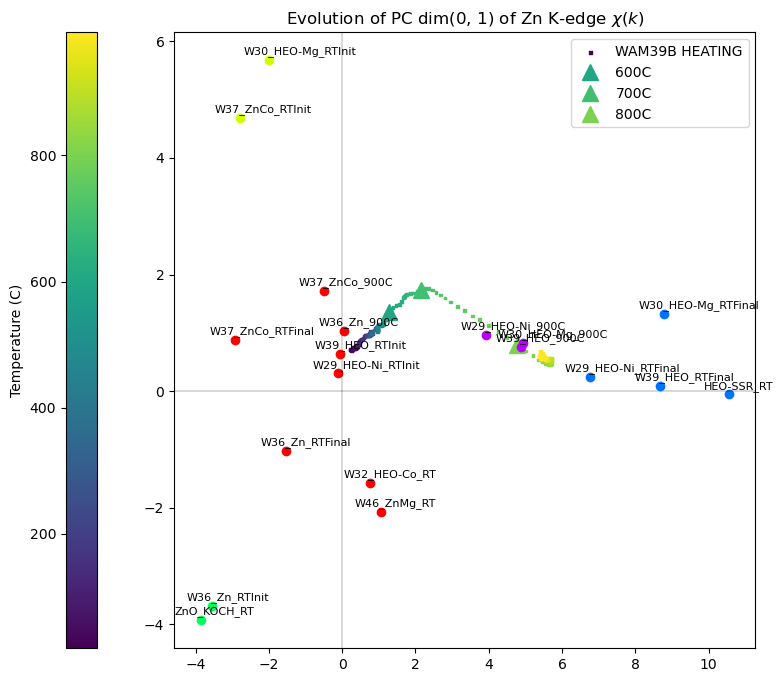

In [80]:
dim0 = 0 # 0, 1, 2, 3, 4, 5; dimensions of the PCA
dim1 = 1
interesting_temperatures = (600, 700, 800) # stuff I pulled from looking at differential spectra / the spectrogram

adj_text_idx = ()#(13, 15) # indices into names_all for which to adjust text position

fig, ax = plt.subplots(figsize=(10,8))

# If not choosing a range, set to None and comment out the xlim/ylim
xrange = None#(-1,7)
yrange = None#(0,2)
# plt.xlim(xrange)
# plt.ylim(yrange)

# Plot experiment
cmap = cm.get_cmap('viridis')
x_embed = savgol_filter(reduced_rock[:, dim0], 9, 2)
y_embed = savgol_filter(reduced_rock[:, dim1], 9, 2)
norm = plt.Normalize(min(temperatures_rock), max(temperatures_rock))
ax.scatter(x_embed, y_embed, c=temperatures_rock, cmap=cmap, marker='s', s=4, label='WAM39B HEATING')
cb = fig.colorbar(cm.ScalarMappable(norm=norm), cmap=cmap, ax=ax, location='left')
cb.ax.set_ylabel("Temperature (C)")
# Re-plot specific temperatures of interest
for T in interesting_temperatures:
    delta = np.abs(np.array(temperatures_rock) - T)
    idx = np.argmin(delta)
    ax.plot(x_embed[idx], y_embed[idx], '^', markersize=12, c=cmap(norm(temperatures_rock[idx])), label=f'{T}C')
    
# Plot references
for i, embedding in enumerate(reduced):
    adj = 0.2 if i in adj_text_idx else 0.
    ax.axhline(0, linewidth=0.01, color='k')
    ax.axvline(0, linewidth=0.01, color='k')
    ax.plot(embedding[dim0], embedding[dim1], 'o', c=cm.hsv(ap.labels_[i]/(max(ap.labels_) + 1)))
    # make annotations
    textx = embedding[dim0]-0.7-adj
    texty = embedding[dim1]+0.1+adj
    if xrange is not None and yrange is not None:
        if xrange[0] < textx < xrange[1] and yrange[0] < texty < yrange[1]:
            ax.text(textx, texty, names_all[i], fontsize=8)
    else:
        ax.text(textx, texty, names_all[i], fontsize=8)
ax.set_title(f"Evolution of PC dim({dim0}, {dim1}) of {elem} K-edge $\chi(k)$")

plt.legend()
plt.savefig(f"Output/ROCK_XAS/PCA_evo/PCA_{elem}_WAM39B_{dim0}_{dim1}", dpi=300)
plt.show()